In [ ]:
from analyze_language_change import Mail, import_corpus, linear_prediction, occurrence_freq_by_year
from pydantic import TypeAdapter
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 

Tagesschau and uni circular mail corpus.

To use bjoernp corpera:
```
from itertools import chain

corpus_18_23 = import_corpus(batch_size=100, streaming=False, url="bjoernp/tagesschau-2018-2023")
corpus_24 = import_corpus(batch_size=100, streaming=False, url="bjoernp/tagesschau-010124-020524")
corpus = chain(corpus_17, corpus_18_23, corpus_24)
```


In [12]:
corpus_12_25 = import_corpus(batch_size=100, streaming=False, url="julilili42/tagesschau")
uni_mails = import_corpus(batch_size=100, streaming=False, url="DerSandmannHD/Uni-Mail", adapter = TypeAdapter(list[Mail]))

In [14]:
rows = [(a.date.year, a.article) for a in uni_mails]
year, articles = zip(*rows)

3096 articles to be loaded for dataset uni-mail


In [15]:
# distribution of articles for years
year_distribution = pd.Series(year).value_counts().sort_index()
# generate word matrix 
vec = CountVectorizer(max_features=100000, binary=True)
word_matrix_bin = vec.fit_transform(articles)
vocab = vec.get_feature_names_out()

Text(0, 0.5, 'Number of articles')

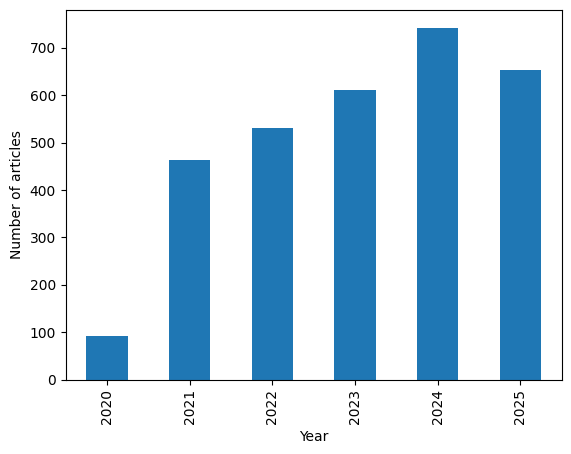

In [16]:
ax = year_distribution.plot(kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("Number of articles")

In [17]:
occurence_freq = occurrence_freq_by_year(year=year, word_matrix_bin=word_matrix_bin, vocab=vocab)

Goal: try to find words which disproportionaly increased in use, by interpolating use in year 2024 

- frequency gap $\delta = p - q$ $\implies$ highlights excess usage of frequent words
- frequency ratio $r = \frac{p}{q}$ $\implies$ highlights excess usage of infrequent words.

In [18]:
# dataframe containing frequencies before introduction of llm's
train = occurence_freq.loc[2012:2022]

# linear interpolation, frequency value of 2024
q = train.apply(linear_prediction, axis=0)

# empirical frequency
p = occurence_freq.loc[2024]

# only keep words with p>1e-4 in 2023 and 2024
mask_freq = (occurence_freq.loc[2023] > 1e-4) & (occurence_freq.loc[2024] > 1e-4)
p = p[mask_freq]
q = q[mask_freq]

# Metric 1: frequency gap delta = p - q
delta = p - q

# Metric 2: frequency ratio r = p/q
eps = 1e-8
r = p / np.maximum(q, eps)

sorted_freq_gap = delta.sort_values(ascending=False).head(20)
sorted_freq_ratio = r.sort_values(ascending=False).head(20)

Definition Excess Words: 
- $\delta > 0.01$ and 
- $\log_{10}\;r > \frac{log_{10}\;2}{4} \cdot log_{10}\;p$

In [19]:
threshold = (np.log10(2) / 4) * np.log10(p)
mask_excess = (delta > 0.01) | (np.log10(r) > threshold)

excess_words = pd.DataFrame({
    "p": p,
    "q": q,
    "delta": delta,
    "r": r
}).loc[mask_excess].sort_values("delta", ascending=False)

print("number of excess words:", len(excess_words))
print(excess_words.head(30))

number of excess words: 6792
                        p         q     delta             r
ist              0.629879  0.260468  0.369411  2.418258e+00
2024             0.371467  0.003446  0.368021  1.077930e+02
eine             0.611036  0.303987  0.307049  2.010072e+00
von              0.706595  0.502290  0.204305  1.406746e+00
dass             0.188425  0.011309  0.177116  1.666162e+01
sehr             0.246299  0.080414  0.165885  3.062898e+00
vor              0.199192  0.055485  0.143707  3.590011e+00
12               0.211306  0.072358  0.138947  2.920260e+00
bzw              0.293405  0.157857  0.135548  1.858677e+00
tel              0.323015  0.194008  0.129007  1.664957e+00
unsere           0.181696  0.054427  0.127269  3.338370e+00
unserer          0.266487  0.142057  0.124430  1.875913e+00
forschung        0.164199  0.040105  0.124094  4.094251e+00
minuten          0.274563  0.150666  0.123897  1.822332e+00
med              0.135935  0.014283  0.121653  9.517526e+00
keine      

In [26]:
# only look at adjectives and verbes
import spacy
nlp = spacy.load("de_core_news_lg")

words = list(excess_words.index)
pos_tags = {}
for doc in nlp.pipe(words, batch_size=500):
    token = doc[0]
    pos_tags[token.text] = token.pos_

allowed_pos = {"ADJ", "VERB"}
style_words = [w for w, pos in pos_tags.items() if pos in allowed_pos]

excess_style_words = excess_words.loc[excess_words.index.isin(style_words)].sort_values("r", ascending=False)

print(f"number of excess style words {len(excess_style_words)}")
print(excess_style_words.head(50))

number of excess style words 1635
                                p    q     delta             r
geehrte                  0.092867  0.0  0.092867  9.286676e+06
aktuellen                0.068641  0.0  0.068641  6.864065e+06
neurologischen           0.064603  0.0  0.064603  6.460296e+06
helfen                   0.060565  0.0  0.060565  6.056528e+06
stattfinden              0.056528  0.0  0.056528  5.652759e+06
persönlichen             0.053836  0.0  0.053836  5.383580e+06
bitten                   0.053836  0.0  0.053836  5.383580e+06
herzlichen               0.051144  0.0  0.051144  5.114401e+06
sprechen                 0.047106  0.0  0.047106  4.710633e+06
leisten                  0.041723  0.0  0.041723  4.172275e+06
gegeben                  0.039031  0.0  0.039031  3.903096e+06
verbessern               0.036339  0.0  0.036339  3.633917e+06
nächsten                 0.032301  0.0  0.032301  3.230148e+06
eigene                   0.032301  0.0  0.032301  3.230148e+06
gesamten             

In [ ]:
# shaise
llm_markers = [
    "relevant", "vielversprechend", "entscheidend", "bedeutend",
    "herausragend", "umfassend", "wesentlich", "innovativ",
    "erheblich", "nahtlos", "effizient", "zentral", "kritisch",
    "vielseitig", "insbesondere", "zugleich", "zunehmend",
    "insbesondere", "zugleich", "daher", "folglich"
]

excess_llm_like = excess_style_words[
    excess_style_words.index.isin(llm_markers)
]
print(excess_llm_like)

Empty DataFrame
Columns: [p, q, delta, r]
Index: []
